## 1. Import Libraries and Constants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import roll_time_series

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_log_error as rmsle

from lightgbm import LGBMRegressor, plot_importance

from storesales.constants import EXTERNAL_TRAIN_PATH, EXTERNAL_OIL_PATH

## 2. Load Data
### Load Sales Data

In [78]:
df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])

### Load Oil Data

In [149]:
oil_df = pd.read_csv(EXTERNAL_OIL_PATH, parse_dates=["date"])
oil_df.set_index("date", inplace=True)
oil_df = oil_df.asfreq("D")
oil_df["dcoilwtico"] = oil_df["dcoilwtico"].interpolate(limit_direction="forward")
oil_df = oil_df.dropna()

## 3. Define Time Range and Create MultiIndex for Missing Dates

In [150]:
train_data_start = df.date.min().date()
train_data_end = df.date.max().date()

multi_idx = pd.MultiIndex.from_product(
    [
        pd.date_range(train_data_start, train_data_end),
        df.store_nbr.unique(),
        df.family.unique(),
    ],
    names=["date", "store_nbr", "family"],
)

## 4. Handle Missing Values and Merge with Oil Data

In [151]:
train_data = (
    df.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()
)
train_data[["sales", "onpromotion"]] = train_data[["sales", "onpromotion"]].fillna(0.0)
train_data.drop("id", axis=1, inplace=True)
train_data = train_data.merge(oil_df, on="date", how="left")

## 5. Select a Family and Prepare Data for Rolling Window

In [152]:
part_data = train_data[
    train_data["family"].isin(["BEVERAGES", "MEATS", "BREAD/BAKERY"])
].copy()

part_data["store_to_family"] = (
    part_data["store_nbr"].astype(str) + "-" + part_data["family"]
)
train_data = part_data[
    ["date", "sales", "onpromotion", "store_to_family", "dcoilwtico"]
].copy()
train_data.rename(columns={"store_to_family": "id", "date": "time"}, inplace=True)

### Interpolate Missing Data

In [155]:
train_data.head()

,time,sales,onpromotion,id,dcoilwtico
3,2013-01-01,NaN,0.0,1-BEVERAGES,NaN
1785,2013-01-02,1091.0,0.0,1-BEVERAGES,93.140000
3567,2013-01-03,919.0,0.0,1-BEVERAGES,92.970000
5349,2013-01-04,953.0,0.0,1-BEVERAGES,93.120000
7131,2013-01-05,1160.0,0.0,1-BEVERAGES,93.146667


In [157]:
train_data["sales"] = train_data["sales"].replace(0, np.nan)

train_data = train_data.sort_values(by=["id", "time"])

train_data["sales"] = train_data.groupby("id")["sales"].transform(
    lambda group: group.interpolate(method="linear", limit_direction="forward")
)

train_data.dropna(inplace=True)

In [168]:
a = pd.Series([np.nan, 2, np.nan, 5])
a.interpolate(method="linear", limit_direction="forward")

0    NaN
1    2.0
2    3.5
3    5.0
dtype: float64

In [160]:
train_data[train_data["id"] == "52-BEVERAGES"].head()

,time,sales,onpromotion,id,dcoilwtico
2799294,2017-04-20,4036.0,0.0,52-BEVERAGES,50.260000
2801076,2017-04-21,4839.0,37.0,52-BEVERAGES,49.640000
2802858,2017-04-22,6343.0,40.0,52-BEVERAGES,49.393333
2804640,2017-04-23,7633.0,39.0,52-BEVERAGES,49.146667
2806422,2017-04-24,5096.0,35.0,52-BEVERAGES,48.900000


## 6. Create Rolling Time Series for Features and Targets
### Rolling Features

In [7]:
data_rolls = roll_time_series(
    train_data,
    column_id="id",
    column_sort="time",
    max_timeshift=30,
    min_timeshift=30,
    rolling_direction=1,
    n_jobs=6,
)

Rolling: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it]


In [8]:
data_rolls["id"] = data_rolls["id"].apply(
    lambda x: (x[0], x[1] + pd.Timedelta("1 day"))
)

### Rolling Target

In [9]:
target_rolls = roll_time_series(
    train_data[["id", "time", "sales"]],
    column_id="id",
    column_sort="time",
    max_timeshift=15,
    min_timeshift=15,
    rolling_direction=-1,
    n_jobs=6,
)

Rolling: 100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


In [10]:
mean_target = target_rolls.groupby("id")["sales"].mean()

## 7. Sample Data

In [11]:
ids = set.intersection(set(mean_target.index), set(data_rolls["id"]))

In [15]:
sampled_indices = pd.Series(list(ids)).sample(n=5000, random_state=42)

sampled_rolls = data_rolls[data_rolls["id"].isin(sampled_indices)]
sampled_target_rolls = target_rolls[target_rolls["id"].isin(sampled_indices)]
sampled_target_mean = mean_target.loc[sampled_indices]

### Clear Memory

In [16]:
del data_rolls, target_rolls, mean_target

## 8. Feature Extraction
### Extract Relevant Features

In [18]:
relevant_featured = extract_relevant_features(
    sampled_rolls,
    sampled_target_mean,
    column_id="id",
    column_sort="time",
    fdr_level=0.01,
    n_jobs=6,
)

Feature Extraction: 100%|██████████| 30/30 [05:37<00:00, 11.26s/it]


### Filter Features Names For LightGBM

In [19]:
relevant_featured.columns = relevant_featured.columns.str.replace(
    r"[^\w\s]", "", regex=True
)
relevant_featured.columns = relevant_featured.columns.str.strip()
relevant_featured.columns = relevant_featured.columns.str.replace(" ", "_")

### Clear Memory

In [20]:
del sampled_rolls, sampled_target_mean

## 9. Train LightGBM Model
### Split Data

In [39]:
X = relevant_featured.copy()
y = sampled_target_rolls.groupby("id")["sales"].apply(list).copy()
y.index = pd.MultiIndex.from_tuples(y.index)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Train Models

In [79]:
def clipped_rmsle(y_true, y_prediction):
    y_prediction = y_prediction.clip(min=0)
    return rmsle(y_true, y_prediction)

In [99]:
LGBMRegressor_kwargs = dict(
    metric="root_mean_squared_error",
    boosting_type="gbdt",
    learning_rate=0.01,
    n_estimators=500,
    num_leaves=25,
    random_state=42,
    n_jobs=6,
    # subsample_for_bin=1000,
    force_row_wise=True,
    objective="regression",
    verbose=1,
)

In [100]:
models = [LGBMRegressor(**LGBMRegressor_kwargs) for _ in range(1)]

In [101]:
for i, model in enumerate(models):
    print(f"Training model {i}")
    model.fit(X_train, y_train.apply(lambda x: x[i]), eval_metric=clipped_rmsle)

Training model 0
[LightGBM] [Info] Total Bins 141721
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 706
[LightGBM] [Info] Start training from score 1069.160314


### Feature Importance

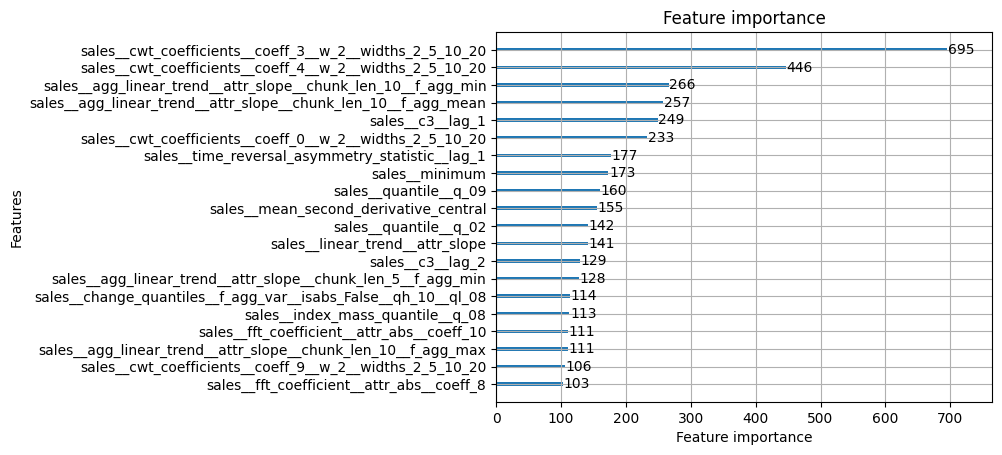

In [103]:
plot_importance(models[0], max_num_features=20, importance_type="split")
plt.show()

### Evaluate Models

In [121]:
for i, model in enumerate(models):
    y_pred = model.predict(X_train)
    rmse = clipped_rmsle(y_train.apply(lambda x: x[i]).values[:8], y_pred[:8])
    print(f"Model {i} RMSE: {rmse}")

Model 0 RMSE: 1.3102393695711065


In [133]:
y_train.apply(lambda x: x[0]).iloc[:10]

50-BREAD/BAKERY  2015-03-06     509.298
6-BREAD/BAKERY   2016-05-09     701.744
17-BREAD/BAKERY  2014-09-27     277.000
45-BREAD/BAKERY  2015-06-26    1270.542
50-BEVERAGES     2014-01-11    5113.000
38-MEATS         2015-06-14     212.483
7-MEATS          2013-03-08     958.979
52-BEVERAGES     2015-06-26       0.000
36-MEATS         2015-11-19     318.363
38-MEATS         2015-09-16     192.020
Name: sales, dtype: float64

In [140]:
y_train.index[7]

('52-BEVERAGES', Timestamp('2015-06-26 00:00:00'))